# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

**Note**

Il dataset contiene 0 valori mancanti per il campo *cfStrutturaProponente* ed 8445 valori mancanti per il campo *cfPrimoaggiudicatario*. I valori mancanti verranno eliminati durante la fase di generazione dei documenti sintetici. Nonostante l'eliminazione di elementi con valori nulli, essendo il dataset molto sporco ci sono diversi  valori inconsistenti. Ad esempio ci sono stringhe formate da soli spazi o di sola punteggiatura speciale, stringhe non associate a reali p.iva o codici fiscali (e.g. "extra UE USA", "USA", "USA00004215"). Per fare ricerche basate su sottostringhe esegui il comando: 

``` python
example_df = df[pd.notnull(df['cfPrimoaggiudicatario'])]
example_df[example_df['cfPrimoaggiudicatario'].str.contains("USA|usa")==True]
```

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term pesati per il loro tf-idf

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale cosi definita:

 
embedding(d<sub>i</sub>) = $ \frac{1}{\sum_{wj∈di} wj} * \sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.



## Soluzione 3: creazione di vettori basati su word embedding dei top term 

   Questa soluzione è molto simile alla precedente. Tuttavia in questa soluzione tutti i termini contribuiscono in ugual misura all'embedding del documento. 
   
   In questo modo è possibile rappresentare d<sub>i</sub> come il centroide dei suoi termini:

 embedding(d<sub>i</sub>) = $ \frac{1}{\{tj | tj∈di\}} * \sum_{tj ∈ di}$ embedding(t<sub>j</sub>)
 
 
## Future Works

1. Al fine di discriminare maggiormente i documenti, si possono analizzare non sono parole di lunghezza 1, ma anche n-grammi (in questo modo documenti come {"fattura luce", "fattura telefono"} risultano meno simili )

In [75]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [76]:
t = time()
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

total = time() - t
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 14.618 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713154 entries, 0 to 1713153
Data columns (total 25 columns):
Unnamed: 0                           int64
cfStrutturaProponente                int64
cig                                  object
denominazioneStrutturaProponente     object
oggetto                              object
sceltaContraente                     object
importoAggiudicazione                float64
importoSommeLiquidate                float64
dataInizio                           object
dataUltimazione                      object
jsonPartecipanti                     object
jsonAggiudicatari                    object
totalePartecipanti                   int64
totaleAggiudicatari                  int64
totaleRaggruppamentopartecipanti     int64
totaleRaggruppamentoAggiudicatari    int64
cfPrimoaggiudicatario                object
denominazionePrimoaggiudicatario     object
cod_amm                              object
regione           

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [77]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

aggregate_df = textual_analysis.createSyntheticDF(df)

pd.options.display.max_colwidth = 500
aggregate_df.shape

Aggregation of attribute cfPrimoaggiudicatario done in 12.422 sec
Aggregation of attribute cfStrutturaProponente done in 1.330 sec


(307265, 3)

In [78]:
t = time()
file_name = "data/oggetti_aggregati.pickle"
aggregate_df.to_pickle(file_name)
total = time() - t

print("Dataset stored in %0.3f sec" % total)

Dataset stored in 0.456 sec


In [80]:
## libera memoria
#una volta lanciato questo comando verranno perse tutte le variabili inizializzate in precedenza
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Creazione Matrice TF-IDF

La matrice dei tf-idf verrà utilizzata per entrambe le soluzioni. Prima di generare la matrice, sono eseguite le seguenti attività di preprocessing:
- Tokenization;
- Eliminazione di stopword (e.g. di, a, dell, quell, etc. );
- Selezione di parole composte solo da lettere e di cardinalità maggiore di 2 (e.g. eliminazione di codici di fattura)

Alla matrice dei tf-idf generata è applicala la norma L2.


Inoltre si visualizzano di seguito le top 40 parole in termini di tf-idf.

In [6]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display


In [129]:
df_file_name = "data/oggetti_aggregati.pickle"

t = time()
df = pd.read_pickle(df_file_name)
total = time() - t

print("Dataset loaded in %0.3f sec" % total)

df.info()

Dataset loaded in 0.162 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307265 entries, 0 to 10965
Data columns (total 3 columns):
codiceFiscaleStruttura    307265 non-null object
oggetto                   307265 non-null object
tipoStruttura             307265 non-null object
dtypes: object(3)
memory usage: 9.4+ MB


In [130]:
t = time()

matrix, tf = textual_analysis.get_TFIDFmatrix_vect(df.oggetto, False)

total = time() - t

print("TFIDF matrix done in %0.3f sec" % total)
print("Shape TFIDF matrix", matrix.shape)

TFIDF matrix done in 16.345 sec
Shape TFIDF matrix (307265, 52004)


In [131]:
import pickle
pickle.dump(tf, open("data/n6/tf.pickle", "wb"))
import scipy
scipy.sparse.save_npz('data/n6/sparse_matrix_tfidf.npz', matrix)

### Plot termini più discriminativi e distribuzione di termini per documento

Si può osservare come è poissibile identificare una decina di termini molto discriminativi (.e. fattura, fornitura, acquisto, pagamento, etc.). Inoltre, si nota che i documenti sintetici generati hanno, nella maggioranza dei casi, un numero di parole distinte compreso tra 6 e 21.

In [132]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = textual_analysis.plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

In [133]:
rows = (matrix != 0).sum(1)
values = np.squeeze(np.asarray(rows))

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


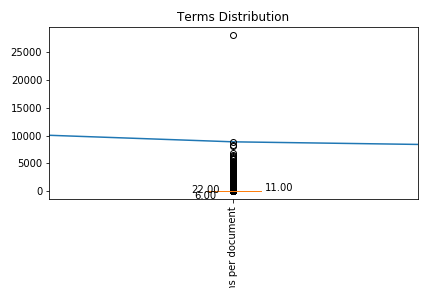

In [134]:
from pylab import text


# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(values)
plt.xticks([1], ["number of terms per document"])
plt.title("Terms Distribution")


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    text(x,y , '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    text(x, y*50, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

f_img = "imgs/n6/term_distribution.png"    
plt.savefig(f_img)
plt.clf()
plt.close()


i = Image(f_img)
display(i)

In [135]:
#seleziona tutti i documenti aventi una rappresentazione tfidf composta di soli zero
states = matrix.getnnz(1)== 0
row_indices = np.where(states)[0]
df.iloc[row_indices].head()

,codiceFiscaleStruttura,oggetto,tipoStruttura
230,000007199,665 ANJEZE PELINI,AGG
405,00013750203,PROORTGEMELLI103354,AGG
1591,00077910289,CONFAGRICOLTURA,AGG
2409,00103590220,CDATAOlive CDATAOlive CDATAOlive,AGG
5090,00167710359,Z601E221B6,AGG


## Implementazione Soluzione 1

Questa implementazione consiste nella sola creazione della matrice tf-idf (salvata in *data/n6/sparse_matrix_tfidf.npz*).

Alla matrice sono state applicate tecniche di dimensionality reduction (i.e. SVD). Tuttavia si è osservato che risultati migliori si sono ottenuti con la sola matrice sparsa. So lascia di seguito la generazione della matrice densa ottenuta applicando SVD e normalizzazione (L2).

In [14]:
#from sklearn.decomposition import TruncatedSVD
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import Normalizer

#t0 = time()
#svd = TruncatedSVD(300)
#normalizer = Normalizer(copy=False)
#preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
#total = time() - t0
#print("Preprocessing done in done in %0.3f sec" % total)

#np.save("data/n6/matrix_tfidf", preprocessing)

## Implementazione Soluzione 2

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e per ogni elemento verrà generata una rappresentazione vettoriale basata su *FastText*. Come per l'implementazione della soluzione 1 verranno analizzati solo i top k termini piu frequenti (i.e. tutti i termini con document frequency > 10).

Output di questa fase saranno la matrice degli embedding (i.e. ) e la matrice degli embedding normalizzata per L2(i.e.)

In [1]:
#il modello appreso da FastText richiede 10 GB di Ram. 
#Quindi potrebbe essere utile rilasciare tutta la memoria allocata e ricaricare solo i dati necessari
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [16]:
import pickle
tf = pickle.load(open("data/n6/tf.pickle", "rb"))

import scipy
matrix = scipy.sparse.load_npz('data/n6/sparse_matrix_tfidf.npz')

In [6]:
from gensim.models import KeyedVectors
t0 = time()
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

total = time() - t0
print("Fastext model loaded in %0.3f sec" % total)

Fastext model loaded in 361.127 sec


Si analizzano di seguito i termini frequenti presenti nella matrice-tfidf ma non presenti in FastText

In [7]:
not_present = []

t0 = time()
for term in tf.vocabulary_:
    if term not in jp_model.vocab:
            not_present.append(term)
total = time() - t0
print("Intersection done in %0.3f sec" % total)        

len_not_present = len(not_present) 
percentage = len_not_present / len(tf.vocabulary_) 
print("Percentage of absent terms: %0.2f (i.e. %d terms)" % (percentage, len_not_present)) 
print("Printing some term not present in Fastext model: ",not_present[:10])

Intersection done in 0.022 sec
Percentage of absent terms: 0.22 (i.e. 11451 terms)
Printing some term not present in Fastext model:  ['vvuu', 'tecnoware', 'cinquefrondi', 'jsibac', 'xtm', 'kiocera', 'ddll', 'aficio', 'audioluci', 'anutel']


In [17]:
t0 = time()
weighted = True
embedded_matrix = textual_analysis.calculate_embedding(tf, matrix, jp_model, matrix.shape[0], weighted)

total = time() - t0 
print("Embedding done in %0.3f sec" % total)

Embedding done in 326.517 sec


In [ ]:
#check how many rows are all zero (it generates divisions by zero)
zero_rows = len(np.where(~embedded_matrix.any(axis=1))[0])
print("there are %d all zero rows" % zero_rows)

In [18]:
t = len(tf.vocabulary_)
f = "data/n6/matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, embedded_matrix)

In [19]:
from sklearn.preprocessing import Normalizer
normalized_matrix = Normalizer(copy=False).fit_transform(embedded_matrix)
f = "data/n6/normalized_matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, normalized_matrix)

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Generazione K nearest neighbors

Si generano di seguito i K nearest neighbors per ogni matrice generata (i.e. Soluzione 1,2 e 3).
In particolare per la matrice **sparsa** tf-idf si utilizzerà l'implementazione fornita da scikit-learn, mentre per le matrici **dense** degli embedding si utilizzerà la libreria *Faiss*.

### Generazione K nearest neighbors per la matrice tf-idf

In [1]:
k = 100

In [18]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [3]:
# matrice sparsa tfidf normalizzata con L2
import scipy.sparse
file_name = "data/n6/sparse_matrix_tfidf.npz"
matrix = scipy.sparse.load_npz(file_name)

In [5]:
t0 = time()
k = 100

I, D = textual_analysis.cosine_similarity_sparseMatrix(matrix, k, 1000)

total = time() - t0

print("K nearest neighbors done in %0.3f sec" % total)

Cosine similarity batch 0 done in 0.055 sec
K nearest neighbors done in 0.056 sec


In [ ]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Generazione K nearest neighbors per la matrice degli embedding

In [6]:
k = 100

In [7]:
#matrice densa embedding non pesata 
file_name = "data/n6/normalized_matrix_embedding_52004terms_weigthedFalse.npy"

#matrice densa embedding pesata con tfidf termini
#file_name = "data/n6/normalized_matrix_embedding_52004terms_weigthedTrue.npy"

matrix = np.load(file_name).astype('float32')

In [8]:
##check how many rows are all zero (it generates divisions by zero)
#zero_rows = len(np.where(~matrix.any(axis=1))[0])
#print("there are %d all zero rows" % zero_rows)

In [9]:
t0 = time()

I, D = textual_analysis.inner_product_denseMatrix(matrix, k)

total = time() - t0
print("Inner Product done in %0.3f sec" % total)

Train index:  True
Total elements to analyze:  307265
Inner Product done in 341.359 sec


In [32]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

### Confronto K nearest neighbors
Di seguito si confrontano i K nearest neighbors estratti attraverso le matrici calcolate in precedenza.

La matrice generata dai tf-idf (i.e. Soluzione 1) sfrutta correlazioni dirette tra termini. Ossia due documenti sono simili se condividono gli stessi termini. Le matrici generate a partire dagli embedding dei termini (i.e. Soluzione 2, Soluzione 3) invece codificano correlazioni indirette tra termini. In quest'ultimo caso, due documenti sono simili se condividono termini semanticamente simili (e.g. raccolta, rifiuti, smaltimento).  

Per verificare se le rappresentazioni estratte per ogni documento codificano le stesse informazioni, si analizza l'intersezione dei k documenti più simili sfruttando le 3 matrici generate:
- Matrice tf-idf
- Matrice embedding
- Matrice embedding pesata con tf-idf

Per ogni coppia di matrici m1,m2, se queste codificano le stesse informazioni, allora per ogni documento d_i:

  
intersection(get_most_similar(m1, i, k), get_most_similar(m2, i, k))  ~= k,

dove *get_most_similar(mj, i, k)* restituisce i k documenti più simili al documento di indice i utilizzando la matrice mj. 


In [33]:
import importlib
importlib.reload(textual_analysis)

<module 'utils.textual_analysis' from '/home/fabiana/git/anacAnalysis/notebooks/utils/textual_analysis.py'>

In [34]:
I_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf= np.load("data/n6/matrix_tfidf.npysimilarity_I_100_k.npy")
D_tfidf = np.load("data/n6/matrix_tfidf.npysimilarity_D_100_k.npy")

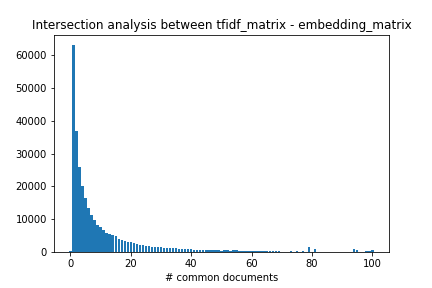

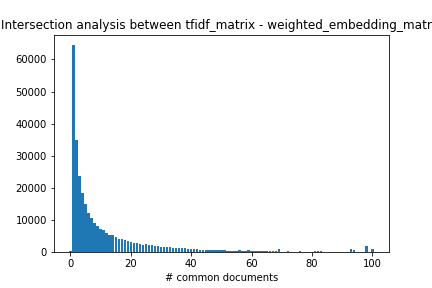

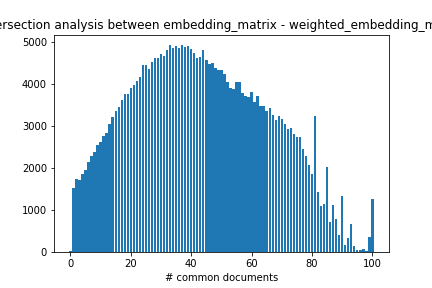

In [38]:
I_array = [I_tfidf, I_embeddings, I_embeddings_weighted]
k = len(I_embeddings[0])
labels = ["tfidf_matrix", "embedding_matrix", "weighted_embedding_matrix"]
intersection_array = []
str_labels = []

for i in range(len(I_array)):
    for j in range(i+1, len(I_array)):
    
        intersection = textual_analysis.get_intersection(I_array[i], I_array[j])
        intersection_array.append(intersection[:100000])
        title = "Intersection analysis between " + labels[i] + " - " + labels[j]
        f_img = "imgs/n6/intersection_"+ labels[i] + "." + labels[j] + "_k"+ str(k)+ ".png"
        str_labels.append(labels[i] + " vs " + labels[j])
        textual_analysis.bar_plot(pd.value_counts(intersection), title,f_img)

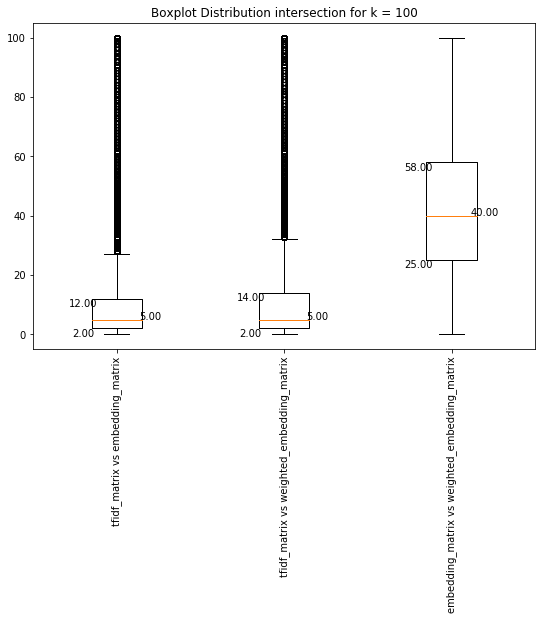

In [40]:
title = "Boxplot Distribution intersection for k = " + str(k)
filename = "imgs/n6/boxplot_comparisons_k"+ str(k)+ ".png"
       
textual_analysis.box_plot(intersection_array, str_labels, title, filename)

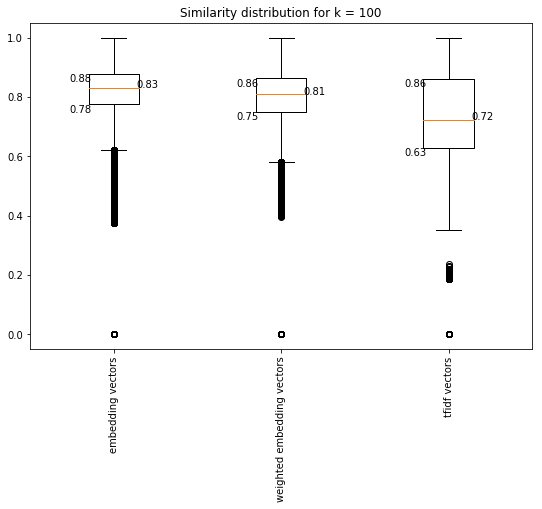

In [42]:
data_to_plot = [D_embeddings.ravel() [:100000], D_embeddings_weighted.ravel()[:100000],D_tfidf.ravel()[:100000]]
axis_labels = ['embedding vectors', 'weighted embedding vectors','tfidf vectors']
title = "Similarity distribution for k = "+ str(k)
filename = "imgs/n6/similarities_comparisons_k"+ str(k)+ ".png"
textual_analysis.box_plot(data_to_plot, axis_labels, title, filename)

### Visualizzazione dettaglio documenti strutture (i.e. Pa e Aggiudicatari) simili

Questa sezione permette di visualizzare in dettaglio i K nearest neighbors di un documento in input (utilizzando il suo indice di riga)
 

In [136]:
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

from utils import textual_analysis

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv
import datetime
from time import time

from IPython.display import Image
from IPython.display import display

In [137]:
I_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedTrue.npysimilarity_D_100_k.npy")

#I_embeddings = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedFalse.npysimilarity_I_100_k.npy")
#D_embeddings = np.load("data/n6/normalized_matrix_embedding_52004terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf= np.load("data/n6/sparse_matrix_tfidf.npzsimilarity_I_100_k.npy")
D_tfidf = np.load("data/n6/sparse_matrix_tfidf.npzsimilarity_D_100_k.npy")

In [138]:
#scegli struttura da analizzare (scelta basata su indice di riga della matrice)
iloc_document_to_compare = 2226 #i.e. si sta analizzando la struttura 2226

I_matrix1 = I_tfidf
D_matrix1 = D_tfidf

#scegli la matrici da confrontare
I_matrix2 = I_embeddings_weighted
D_matrix2 = D_embeddings_weighted


In [139]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df_aggregati = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df_aggregati.info()

Dataset loaded in 0.162 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307265 entries, 0 to 10965
Data columns (total 3 columns):
codiceFiscaleStruttura    307265 non-null object
oggetto                   307265 non-null object
tipoStruttura             307265 non-null object
dtypes: object(3)
memory usage: 9.4+ MB


In [140]:
import pickle
tf = pickle.load(open("data/n6/tf.pickle", "rb"))

import scipy
m = scipy.sparse.load_npz('data/n6/sparse_matrix_tfidf.npz')

In [141]:
pd.options.display.max_colwidth = 500
df_aggregati.iloc[[iloc_document_to_compare]]

,codiceFiscaleStruttura,oggetto,tipoStruttura
2226,00099510216,Weinlieferung fornitura vini Wein vino ordine vino Bestellung Weine,AGG


In [142]:
commons_docs =  set(I_matrix1[iloc_document_to_compare]).intersection(set(I_matrix2[iloc_document_to_compare]))
df_most_similar = df_aggregati.iloc[list(commons_docs)]
df_most_similar["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), commons_docs, 40)
df_most_similar.head()

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,codiceFiscaleStruttura,oggetto,tipoStruttura,top_terms
2226,00099510216,Weinlieferung fornitura vini Wein vino ordine vino Bestellung Weine,AGG,vino:0.54 weinlieferung:0.41 weine:0.40 bestellung:0.38 wein:0.36 vini:0.28 ordine:0.15 fornitura:0.10


### K nearest neighbors using tf-idf

In [143]:
best_docs = I_matrix1[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix1[iloc_document_to_compare]
matrix_docs

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,codiceFiscaleStruttura,oggetto,tipoStruttura,top_terms,cosine_similarity
2226,00099510216,Weinlieferung fornitura vini Wein vino ordine vino Bestellung Weine,AGG,vino:0.54 weinlieferung:0.41 weine:0.40 bestellung:0.38 wein:0.36 vini:0.28 ordine:0.15 fornitura:0.10,1.00
2449,00104377076,Fornitura materiale dUfficio Fornitura materiale dUfficio Affidamento installazione configurazione e manutenzione computer Affidamento fornitura materiale dUfficio Riparazione macchina per ufficio,AGG,dufficio:0.77 materiale:0.33 fornitura:0.27 configurazione:0.21 macchina:0.20 computer:0.20 affidamento:0.18 installazione:0.16 ufficio:0.15 riparazione:0.12 manutenzione:0.10,0.59
2175,00098210057,RIPARAZIONE AUTOCARRO GENEROSA RICAMBI AUTOMEZZI PROPRIETA COMUNALE TRATTORE SAME EXPLORER AFFIDAMENTO ALLA DITTA FLLI AMATO SNC IMPEGNO DI SPESA,AGG,generosa:0.43 amato:0.37 explorer:0.35 same:0.33 trattore:0.26 flli:0.25 autocarro:0.23 ricambi:0.22 proprieta:0.21 snc:0.20 automezzi:0.19 riparazione:0.14 comunale:0.13 ditta:0.13 impegno:0.11 spesa:0.11 affidamento:0.10,0.58
2041,00093290427,Ordine acquisto di caramelle e dolcetti per Babbi Natale e La Befana 2018,AGG,caramelle:0.65 befana:0.58 natale:0.36 ordine:0.26 acquisto:0.18,0.56
1925,00089790893,Pagamento Fattura n7PA del 25112017 Pagamento Fattura n5PA del 28082017 Pagamento Fattura n6PA del 21092017,AGG,pa:0.66 pagamento:0.55 fattura:0.51,0.56
174,00000018446,Inserimento pagina Rally PO sul sito Rally Link,AGG,rally:0.76 link:0.37 pagina:0.34 inserimento:0.26 po:0.25 sito:0.21,0.56
2275,00100682095,CIG ZC51E29A14 AFFIDAMENTO LAVORI DI MONTAGGIO DI GIOCHI LUDICI,AGG,ludici:0.68 giochi:0.38 zc:0.37 montaggio:0.36 cig:0.21 lavori:0.21 affidamento:0.18,0.56
7547,00231382107,ABBONAMENTO TELEMACO 2018,AGG,telemaco:0.86 abbonamento:0.51,0.56
834,00046830329,TAPPI PER IMBOTTIGLIAMENTO VINI fattura n 3 del 06112017 per fornitura materiale per cantina didattica,AGG,imbottigliamento:0.55 cantina:0.45 tappi:0.43 vini:0.40 didattica:0.27 materiale:0.17 fattura:0.16 fornitura:0.14,0.55
7889,00240930164,COMPARTECIPAZIONE DELLE SPESE DEL PIANO DI ZONA ANNO 2017,AGG,compartecipazione:0.65 zona:0.46 piano:0.39 spese:0.36 anno:0.29,0.55


### K nearest neighbors using embedding 

In [145]:
best_docs = I_matrix2[iloc_document_to_compare]
matrix_docs = df_aggregati.iloc[best_docs]
matrix_docs["top_terms"] = textual_analysis.get_best_terms_frequencies(m, tf.get_feature_names(), best_docs, 20)
matrix_docs["cosine_similarity"] = D_matrix2[iloc_document_to_compare]
matrix_docs

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,codiceFiscaleStruttura,oggetto,tipoStruttura,top_terms,cosine_similarity
2226,00099510216,Weinlieferung fornitura vini Wein vino ordine vino Bestellung Weine,AGG,vino:0.54 weinlieferung:0.41 weine:0.40 bestellung:0.38 wein:0.36 vini:0.28 ordine:0.15 fornitura:0.10,1.000000
3445,00126870211,Wein vino Wein vino Acquisto vini per catering ANUGA Ankauf Weine f r Catering ANUGA Wein Vino Wein Vino,AGG,wein:0.70 vino:0.52 anuga:0.34 catering:0.22 weine:0.19 ankauf:0.14 vini:0.13 acquisto:0.05,0.968855
3427,00126570217,Fornitura di vino Weinlieferung vini per catering manistazione Wein f r Veranstaltungscatering ordine vino Bestellung Weine vini per manifestazione Weine f r Veranstaltung Vini per il ballo scolastico Acquisto vino Fornitura di vino per lo stand di Lagundo nel comune gemellato Etzenricht,AGG,vino:0.56 vini:0.43 weine:0.41 weinlieferung:0.21 gemellato:0.20 bestellung:0.19 wein:0.19 lagundo:0.18 veranstaltung:0.18 ballo:0.16 stand:0.14 catering:0.12 fornitura:0.10 manifestazione:0.09 scolastico:0.09 ordine:0.08 comune:0.08 acquisto:0.05,0.963760
48677,01255160218,Weinlieferung fornitura vini Eventoevento Media Days Kronplatz vini per manifestzione WEine f r Veranstaltung Fornitura vino per catering fiera ANUGA Lieferung Wein f r Catering Messe ANUGA Wein Vino Wein Vino,AGG,wein:0.55 vino:0.41 anuga:0.36 vini:0.28 catering:0.23 kronplatz:0.21 weinlieferung:0.21 weine:0.20 veranstaltung:0.17 days:0.17 messe:0.16 lieferung:0.15 fiera:0.11 fornitura:0.10 media:0.09,0.951408
22280,00690730213,acquisto vino Ankauf Wein,AGG,wein:0.66 ankauf:0.52 vino:0.50 acquisto:0.19,0.938097
272482,NTRJFM63P16L724B,Wein vino,AGG,wein:0.80 vino:0.60,0.932036
2163,00098020217,Wein Vino,AGG,wein:0.80 vino:0.60,0.932036
263324,MCKCRS72P04A952I,Wein Vino Wein Vino,AGG,wein:0.80 vino:0.60,0.932036
3138,00121460216,Vino per fiera Wein f r Messe fornitura vini Lieferung Wein Fornitura vini per Fiera Tip World a Brunico Fornitura vini Weinlieferung f r Presseevent Paris Vino per evento stampa Wein f r Presseevent Vino fiera del libro Pinot Bianco DOC e Pinot Nero DOC Fornitura vino per catering fiera ANUGA Lieferung Wein f r Catering Messe ANUGA vini per manifestazione Weine f r Veranstaltung Wein Vino Wein Vino Fornitura di vino giovane non trattato delle varit Schiava e Lagrein,AGG,wein:0.56 vino:0.49 vini:0.29 fiera:0.22 presseevent:0.21 pinot:0.21 anuga:0.18 messe:0.16 lieferung:0.16 doc:0.14 fornitura:0.12 catering:0.12 weinlieferung:0.11 weine:0.10 trattato:0.09 paris:0.09 tip:0.09 veranstaltung:0.09 giovane:0.09 world:0.08,0.924916
217798,82003750260,fornitura di vino in degustazione fornitura di vino concerto a Roma e manifestazioni fornitura vino in degustazione fornitura vino in degustazione fornitura di vino degustazioni fornitura di vino per degustazioni CERLETTI VINI CIG ANNUALE FINO 311217,AGG,vino:0.76 degustazione:0.43 degustazioni:0.33 fornitura:0.27 vini:0.13 concerto:0.10 manifestazioni:0.10 fino:0.10 roma:0.09 annuale:0.08 cig:0.05,0.898744
